# Кейс. Золотая Жила 2.

In [23]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as smp
from tqdm import tqdm

df = pd. read_csv('https://raw.githubusercontent.com/zalig/cu-datasets/main/golden_mine.csv')

df['Gender'] = df['Gender'].str.replace('FEMALE', 'female').replace('Female', 'female')
df = df[ (df['Profit'] < 1000000) & (df['Profit'] > -1000000) ]

df.head(5)

,Payments,Costs,Profit,Age,Gender,AgeGroup
0,9400,8100,1300,19,male,18-24
1,26600,13900,12700,29,male,25-39
2,9750,6750,3000,20,male,18-24
3,29700,11200,18500,18,female,18-24
4,49700,10450,39250,21,female,18-24


# Важные функции

In [24]:
# Одновыборочный z-тест
def ztest_1sample(pop_mean,
                  sample_mean,
                  sample_std,
                  sample_size,
                  alternative='two-sided'):

    statistic = (sample_mean - pop_mean)/(sample_std / sample_size**0.5)

    if alternative == 'less':
        pvalue = sps.norm.cdf(statistic)

    if alternative == 'greater':
        pvalue = 1 - sps.norm.cdf(statistic)

    if alternative == 'two-sided':
        pvalue = 2 * (1 - sps.norm.cdf(abs(statistic)))

    return statistic, pvalue




def ztest_1sample_data(pop_mean, sample, alternative='two-sided'):

    return ztest_1sample(pop_mean, sample_mean = sample.mean(),
                         sample_std = sample.std(),
                         sample_size = len(sample),
                         alternative = alternative)

# Двухвыборочный z-тест
def ztest_2sample(sample1_mean,
                  sample2_mean,
                  sample1_std,
                  sample2_std,
                  sample1_size,
                  sample2_size,
                  alternative='two-sided'):

    statistic = (sample1_mean - sample2_mean) / (sample1_std ** 2 / sample1_size + sample2_std ** 2 / sample2_size) ** 0.5

    if alternative == 'less':
        pvalue = sps.norm.cdf(statistic)

    if alternative == 'greater':
        pvalue = 1 - sps.norm.cdf(statistic)

    if alternative == 'two-sided':
        pvalue = 2 * (1 - sps.norm.cdf(abs(statistic)))

    return statistic, pvalue


# Подсчёт мощности одновыборочного правостороннего теста методом Монте-Карло
def ztest_2sample_data(sample1,
                       sample2,
                       alternative='two-sided'):

    return ztest_2sample(sample1_mean = sample1.mean(),
                         sample2_mean = sample2.mean(),
                         sample1_std = sample1.std(),
                         sample2_std = sample2.std(),
                         sample1_size = len(sample1),
                         sample2_size = len(sample2),
                         alternative = alternative)

def zpower_1sample_data_monte_carlo(mu0,
                                    mu,
                                    sigma,
                                    sample_size,
                                    n_monte_carlo,
                                    significance_level = 0.05):

    rejections = 0

    for _ in range(n_monte_carlo):
        sample = sps.norm.rvs(loc=mu, scale=sigma, size=sample_size)
        test_stat, pvalue = ztest_1sample(pop_mean  = mu0,
                                          sample_mean = sample.mean(),
                                          sample_std=sample.std(),
                                          sample_size = len(sample),
                                          alternative = 'greater')

        if pvalue < significance_level:
            rejections += 1

    return rejections / n_monte_carlo

# Синий уровень погнали

## Количество клиентов

In [25]:
print(f'Количество клиентов: {len(df)}')

Количество клиентов: 8713


## Средняя прибыль с клиента

In [26]:
mean_profit = df['Profit'].mean()
print(f'Средняя прибыль с клиента: {mean_profit}')

Средняя прибыль с клиента: 15755.095833811545


## Тест статистической значимости привлечения клиентов без таргетирования

Гипотезы:

  $H_0: \mu - 15000 = 0$ — средняя прибыль от привлечения без таргетирования равна нулю

  $H_1: \mu -15000 > 0$ — средняя прибыль от привлечения без таргетирования больше нуля
  
  Тест:

  Одновыборочный правосторонний z-test

In [27]:
z_st, p_value = ztest_1sample_data(pop_mean = 0,
                                   sample = df['Profit'] - 15000,
                                   alternative = 'greater')

print('p-value:', p_value)

p-value: 0.00023079035103212853


 Нет статистических доказательств прибыльности привлечения без таргетирования

## Датасеты М24 и Ж24

In [28]:
male_18_24 = df[ (df['Gender'] == 'male') & (df['AgeGroup'] == '18-24') ].copy()
female_18_24 = df[ (df['Gender'] == 'female') & (df['AgeGroup'] == '18-24') ].copy()

Гипотезы:

$H_0: \mu_M = \mu_F$ — средняя прибыль в категории "Мужчины 18-24" совпадает со средней прибыльностью в категории \
  "Женщины 18-24"

$H_1: \mu_M \neq \mu_F$ — средняя прибыль в категории "Мужчины 18-24" **не** совпадает со средней прибыльностью в категории "Женщины 18-24"

Тест:

Двухвыборочный двусторонний z-test

In [29]:
z_st, p_value = ztest_2sample_data(sample1 = male_18_24['Profit'],
                                   sample2 = female_18_24['Profit'],
                                   alternative = 'two-sided')

print('p-value:', p_value)

p-value: 0.0


  $p-value = 0 < 0.05 = \alpha$

  Вывод: гипотеза $H_0$ отвергается в пользу гипотезы $H_1$, т.е. мы имеем достаточно статистических свидетельств того, что средняя прибыль в категории "Мужчины 18-24" не совпадает со средней прибылью в категории "Женщины 18-24"

Проведём тесты значимости прибыльности привлечения клиентов в каждой
из категорий

Гипотезы:

$H_0: \mu = 0$ — средняя прибыль от привлечения категории клиентов равна нулю

$H_1: \mu > 0$ — средняя прибыль от привлечения категории клиентов положительная

Тест:

Одновыборочный правосторонний z-test

In [30]:
z_st, p_value = ztest_1sample_data(pop_mean = 0,
                                   sample = male_18_24['Profit'] - 15000,
                                   alternative = 'greater')
print('"Мужчины 18-24" p-value:', p_value)

z_st, p_value = ztest_1sample_data(pop_mean = 0,
                                   sample = female_18_24['Profit'] - 15000,
                                   alternative = 'greater')
print('"Женщины 18-24" p-value:', p_value)

"Мужчины 18-24" p-value: 0.9999759917034207
"Женщины 18-24" p-value: 0.0


Получаем достаточно статистических свидетельств того, что прибыль от привлечения клиентов категории "Мужчины 18-24" не будет положительной, в то же время прибыль от привлечения "Женщин 18-24" должна быть положительной и значимо отличаться от первой категории (согласно результатам предыдущего теста)

Выбираем категорию "Женщины 18-24"

# Красный уровень сюда

In [31]:
print('Уровень значимости для каждого теста:', round(5/3, 2))

Уровень значимости для каждого теста: 1.67


## Тест статистической значимости разницы между категориями Ж21 и Ж24

Гипотезы:

$H_0: \mu_1 = \mu_2$ — средняя прибыль первой категории совпадает со средней прибылью второй категории

$H_1: \mu_1 \neq \mu_2$ — средняя прибыль первой категории не равна средней прибыли второй категории

Тест:

Двухвыборочный двусторонний z-test

In [32]:
female_18_21 = female_18_24[ female_18_24['Age'] <= 21 ].copy()
female_22_24 = female_18_24[ female_18_24['Age'] > 21 ].copy()

In [33]:
z_st, p_value = ztest_2sample_data(sample1 = female_18_21['Profit'],
                                   sample2 = female_22_24['Profit'],
                                   alternative = 'two-sided')

print('p-value:', p_value)

p-value: 0.0


  $p-value = 0 < 0.0167 = \alpha$

  Вывод: гипотеза $H_0$ отвергается в пользу гипотезы $H_1$, т.е. мы имеем достаточно статистических свидетельств того, что средняя прибыль в категории "Женщины 18-21" не совпадает со средней прибылью в категории "Женщины 22-24"

## Тест статистической значимости разницы между прибылью и расходами на привлечение

Гипотезы:

$H_0: \mu = 15000$ — средняя прибыль от привлечения подкатегории равна средним затратам на привлечение

$H_1: \mu > 15000$ — средняя прибыль от привлечения подкатегории больше средних затрат на привлечение

Тест:

Одновыборочный правосторонний z-test

In [34]:
z_st, p_value = ztest_1sample_data(pop_mean = 15000,
                                   sample = female_18_21['Profit'],
                                   alternative = 'greater')

print('"Женщины 18-21" p-value:', p_value)

z_st, p_value = ztest_1sample_data(pop_mean = 15000,
                                   sample = female_22_24['Profit'],
                                   alternative = 'greater')

print('"Женщины 22-24" p-value:', p_value)

female_18_21['Profit'].mean(), female_22_24['Profit'].mean()

"Женщины 18-21" p-value: 0.0
"Женщины 22-24" p-value: 0.0


(25716.510438858117, 29891.23287671233)

  $p-value_{1, 2} = 0 < 0.0167 = \alpha$

  Вывод: гипотеза $H_0$ отвергается в пользу гипотезы $H_1$, т.е. мы имеем достаточно статистических свидетельств того, что в обеих подкатегориях средняя прибыль от привлечения подкатегории больше средних затрат на привлечение

In [35]:
print('Уровень значимости для каждого теста:', round(5/21, 2))

Уровень значимости для каждого теста: 0.24


Такой маленький уровень значимости неудобен тем, что тест будет детектировать только очень большие разницы в прибыльности, т.е. необходимая мощность в $80 \%$ при заданном уровне значимости достигается при очень большом минимально детектируемом эффекте

Построим таблицу со значениями $p-value$ для каждых 2-х категорий

In [36]:
ages = sorted(list(female_18_24['Age'].unique()))
pvalue_matrix = np.full((len(ages), len(ages)), np.nan)

for ind_1, cat_1 in enumerate(ages):
    for ind_2, cat_2 in enumerate(ages):
        sample1 = female_18_24[female_18_24['Age'] == cat_1]['Profit']
        sample2 = female_18_24[female_18_24['Age'] == cat_2]['Profit']
        z_stat, p_value = ztest_2sample_data(sample1, sample2, alternative='two-sided')
        pvalue_matrix[ind_1, ind_2] = p_value
        pvalue_matrix[ind_2, ind_1] = p_value

pvalue_df = pd.DataFrame(pvalue_matrix, index=ages, columns=ages)
alpha = 0.05 / 21
def colored_pvalue(pvalue):
    if pvalue < alpha:
        color = 'hotpink'
    elif pvalue == 1:
        color = 'white'
    else:
        color = 'lightpink'
    return f'background-color: {color}'

styled_df = pvalue_df.style.map(colored_pvalue).format("{:.3f}")
styled_df

,18,19,20,21,22,23,24
18,1.000,0.409,0.649,0.000,0.000,0.000,0.000
19,0.409,1.000,0.844,0.000,0.000,0.000,0.000
20,0.649,0.844,1.000,0.001,0.004,0.000,0.011
21,0.000,0.000,0.001,1.000,0.665,0.050,0.538
22,0.000,0.000,0.004,0.665,1.000,0.032,0.821
23,0.000,0.000,0.000,0.050,0.032,1.000,0.028
24,0.000,0.000,0.011,0.538,0.821,0.028,1.000


## Абсолютные значения разницы средней прибыли для каждых 2-х категорий

In [37]:
ages = sorted(list(female_18_24['Age'].unique()))
delta_profit_matrix = np.full((len(ages), len(ages)), np.nan)

for ind_1, cat_1 in enumerate(ages):
    for ind_2, cat_2 in enumerate(ages):
        mean_profit_1 = female_18_24[female_18_24['Age'] == cat_1]['Profit'].mean()
        mean_profit_2 = female_18_24[female_18_24['Age'] == cat_2]['Profit'].mean()
        delta_profit_matrix[ind_1, ind_2] = mean_profit_1 - mean_profit_2

delta_profit_df = pd.DataFrame(delta_profit_matrix, index=ages, columns=ages)
def colored_delta_profit(delta_profit, i, j):
    global pvalue_df
    alpha = 0.05 / 21
    pvalue = pvalue_df.loc[i, j]
    if pvalue < alpha:
        color = 'hotpink'
    elif pvalue == 1:
        color = 'white'
    else:
        color = 'lightpink'
    return f'background-color: {color}'

styled_df = delta_profit_df.style.apply(lambda x: [colored_delta_profit(delta_profit_df.loc[x.name, col], x.name, col) for col in x.index], axis = 1).format("{:.3f}")
styled_df

,18,19,20,21,22,23,24
18,0.000,-324.258,-575.113,-4881.056,-4531.113,-7620.340,-4306.250
19,324.258,0.000,-250.855,-4556.797,-4206.855,-7296.082,-3981.991
20,575.113,250.855,0.000,-4305.943,-3956.000,-7045.227,-3731.136
21,4881.056,4556.797,4305.943,0.000,349.943,-2739.285,574.806
22,4531.113,4206.855,3956.000,-349.943,0.000,-3089.227,224.864
23,7620.340,7296.082,7045.227,2739.285,3089.227,0.000,3314.091
24,4306.250,3981.991,3731.136,-574.806,-224.864,-3314.091,0.000


Получаем, что тест начинает детектировать значимость разницы в категориях, если эта разница на наших данных составляет не менее 3956 рубля

Для наглядности покажем среднюю прибыль в каждой категории из самого первого кейса "Золотая жила"

Наиболее прибыльной будет возрастная категория с максимальной суммой по строке в датафрейме - в нашем случае, 23 года

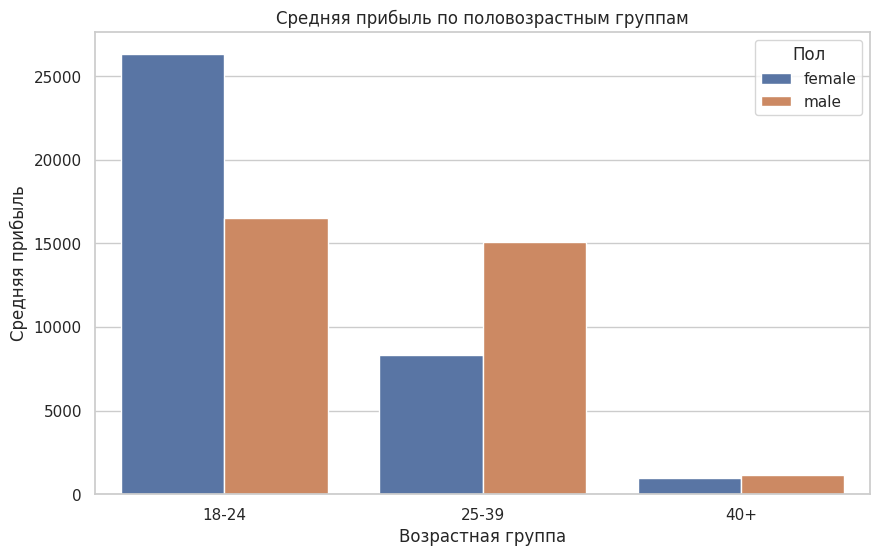

Аналогичная ситуация для попарного тестирования значимости разницы в категориях "Мужчины 18 лет", . . . , "Мужчины 24 года", из-за большого MDE будет трудно обнаружить самую прибыльную категорию, если средняя прибыль в них отличается не очень сильно

Построим таблицу со значениями $p-value$ для каждых 2-х категорий

In [38]:
ages = sorted(list(male_18_24['Age'].unique()))
pvalue_matrix = np.full((len(ages), len(ages)), np.nan)

for ind_1, cat_1 in enumerate(ages):
    for ind_2, cat_2 in enumerate(ages):
        sample1 = male_18_24[male_18_24['Age'] == cat_1]['Profit']
        sample2 = male_18_24[male_18_24['Age'] == cat_2]['Profit']
        z_stat, p_value = ztest_2sample_data(sample1, sample2, alternative='two-sided')
        pvalue_matrix[ind_1, ind_2] = p_value
        pvalue_matrix[ind_2, ind_1] = p_value
pvalue_df = pd.DataFrame(pvalue_matrix, index=ages, columns=ages)
alpha = 0.05 / 21

def colored_pvalue(pvalue):
    if pvalue < alpha:
        color = 'royalblue'
    elif pvalue == 1:
        color = 'white'
    else:
        color = 'lightblue'
    return f'background-color: {color}'

styled_df = pvalue_df.style.map(colored_pvalue).format("{:.3f}")
styled_df

,18,19,20,21,22,23,24
18,1.000,0.538,0.088,0.000,0.000,0.000,0.000
19,0.538,1.000,0.280,0.000,0.000,0.000,0.000
20,0.088,0.280,1.000,0.000,0.000,0.000,0.000
21,0.000,0.000,0.000,1.000,0.345,0.229,0.884
22,0.000,0.000,0.000,0.345,1.000,0.777,0.481
23,0.000,0.000,0.000,0.229,0.777,1.000,0.368
24,0.000,0.000,0.000,0.884,0.481,0.368,1.000


Найдем абсолютные значения разницы средней прибыли для каждых 2-х категорий

In [39]:
ages = sorted(list(male_18_24['Age'].unique()))
delta_profit_matrix = np.full((len(ages), len(ages)), np.nan)

for ind_1, cat_1 in enumerate(ages):
    for ind_2, cat_2 in enumerate(ages):
        mean_profit_1 = male_18_24[male_18_24['Age'] == cat_1]['Profit'].mean()
        mean_profit_2 = male_18_24[male_18_24['Age'] == cat_2]['Profit'].mean()
        delta_profit_matrix[ind_1, ind_2] = mean_profit_1 - mean_profit_2
delta_profit_df = pd.DataFrame(delta_profit_matrix, index=ages, columns=ages)

def colored_delta_profit(delta_profit, i, j):
    global pvalue_df
    alpha = 0.05 / 21
    pvalue = pvalue_df.loc[i, j]
    if pvalue < alpha:
        color = 'royalblue'
    elif pvalue == 1:
        color = 'white'
    else:
        color = 'lightblue'
    return f'background-color: {color}'

styled_df = delta_profit_df.style.apply(lambda x: [colored_delta_profit(delta_profit_df.loc[x.name, col], x.name, col) for col in x.index], axis = 1).format("{:.3f}")
styled_df

,18,19,20,21,22,23,24
18,0.000,56.564,176.818,-76759.877,-77970.333,-78451.569,-76487.029
19,-56.564,0.000,120.254,-76816.441,-78026.897,-78508.133,-76543.593
20,-176.818,-120.254,0.000,-76936.695,-78147.152,-78628.387,-76663.847
21,76759.877,76816.441,76936.695,0.000,-1210.456,-1691.692,272.848
22,77970.333,78026.897,78147.152,1210.456,0.000,-481.235,1483.304
23,78451.569,78508.133,78628.387,1691.692,481.235,0.000,1964.540
24,76487.029,76543.593,76663.847,-272.848,-1483.304,-1964.540,0.000


Получаем, что тест начинает детектировать значимость разницы в категориях, если эта разница на наших данных составляет не менее 1964 рубля

Для наглядности покажем среднюю прибыль в каждой категории из самого первого кейса "Золотая жила"

Наиболее прибыльной будет возрастная категория с максимальной суммой по строке в датафрейме - в нашем случае найденная в первом кейсе "Золотая жила" - мужчины 21-24

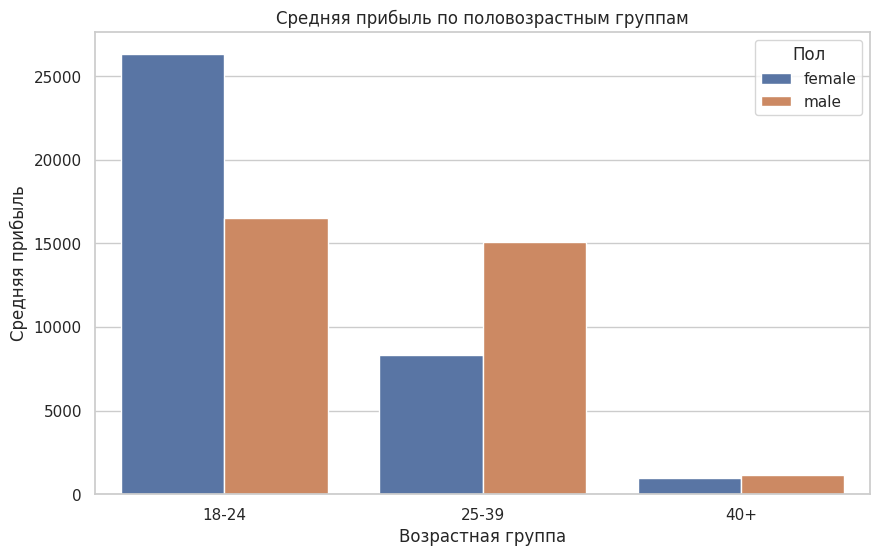

Таким образом, т.к. мы имеем большое количество данных и средний чек достаточно большой, такое маленькое значение уровня значимости не мешает, а наоборот, помогает найти наиболее выделяющуюся по прибыли категорию/категории клиентов

# Ну чё чёрный

In [40]:
golden_vein = df[ (df['Gender'] == 'male') & (df['Age'] >= 21) & (df['Age'] <= 24) ]

Проверим значимость разницы в прибыльности категорий
"Золотая жила" и "Женщины 18-24 лет":

Гипотезы:

$H_0: \mu_G = \mu_F$ — средняя прибыль первой категории совпадает со средней прибылью второй категории

$H_1: \mu_G \neq \mu_F$ — средняя прибыль первой категории не равна средней прибыли второй категории

Тест:

Двухвыборочный двусторонний z-test

In [41]:
z_st, p_value = ztest_2sample_data(sample1 = female_18_24['Profit'],
                                   sample2=golden_vein['Profit'],
                                   alternative='two-sided')
print('p-value:', p_value)

p-value: 0.0


$p-value = 0 < 0.05 = \alpha$

Вывод: гипотеза $H_0$ отвергается в пользу гипотезы $H_1$, т.е. мы имеем достаточно статистических свидетельств того, что прибыльность в категориях отличается

Определим минимальный детектируемый эффект в тесте,
проверяющем, что прибыль в категории «Мужчины 18 лет» выше стоимости
привлечения:

Гипотезы:

$H_0: \mu = 15000$ — средняя прибыль от привлечения подкатегории равна средним затратам на привлечение

$H_1: \mu > 15000$ — средняя прибыль от привлечения подкатегории больше средних затрат на привлечение

Тест:

Одновыборочный правосторонний z-test

In [42]:
male_18 = df[ (df['Gender'] == 'male') & (df['Age'] == 18) ].copy()

In [43]:
effects = np.arange(0, 500, 1)
for effect in effects:
    if zpower_1sample_data_monte_carlo(mu0 = 15000,
                                       mu = 15000 + effect,
                                       sigma = male_18['Profit'].std(),
                                       sample_size = len(male_18['Profit']),
                                       n_monte_carlo = 1000) >= 0.8:

        print('Минимально детектируемый эффект:', effect)
        break

Минимально детектируемый эффект: 145


Вывод:

Тест обнаружит положительное различие между стоимостью привлечения категории "Мужчины 18 лет" и прибылью с вероятностью $\geq 80 \%$, если это различие будет не менее $138$ рублей

Определим минимальный детектируемый эффект в серии тестов,
проверяющих, что прибыль хотя бы в одной из категорий в категории
«Мужчины 18 лет», «Мужчины 19 лет», ... «Мужчины 24 лет» выше стоимости
привлечения:

Гипотезы:

$H_0: \mu = 15000$ — средняя прибыль от привлечения подкатегории равна средним затратам на привлечение

$H_1: \mu > 15000$ — средняя прибыль от привлечения подкатегории больше средних затрат на привлечение

Тест:

Одновыборочный правосторонний $z-test$

Необходимый уровень значимости $\frac{\alpha}{7} \approx 0.71 \%$, т.к. тесты зависимы

In [44]:
print('Уровень значимости для каждого теста:', round(5/7, 2))

Уровень значимости для каждого теста: 0.71


In [45]:
male_19 = df[ (df['Gender'] == 'male') & (df['Age'] == 19) ].copy()
male_20 = df[ (df['Gender'] == 'male') & (df['Age'] == 20) ].copy()
male_21 = df[ (df['Gender'] == 'male') & (df['Age'] == 21) ].copy()
male_22 = df[ (df['Gender'] == 'male') & (df['Age'] == 22) ].copy()
male_23 = df[ (df['Gender'] == 'male') & (df['Age'] == 23) ].copy()
male_24 = df[ (df['Gender'] == 'male') & (df['Age'] == 24) ].copy()

In [46]:
effects = np.arange(100, 1000, 1)
for effect in effects:
    if zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_18['Profit'].std(), sample_size=len(male_18['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_19['Profit'].std(), sample_size=len(male_19['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_20['Profit'].std(), sample_size=len(male_20['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_21['Profit'].std(), sample_size=len(male_21['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_22['Profit'].std(), sample_size=len(male_22['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_23['Profit'].std(), sample_size=len(male_23['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=male_24['Profit'].std(), sample_size=len(male_24['Profit']), n_monte_carlo=1000, significance_level=0.05 / 7) >= 0.8:
        print('Минимально детектируемый эффект:', effect)
        break

Минимально детектируемый эффект: 191


Вывод:

Тесты обнаружат положительное различие между стоимостью привлечения хотя бы одной из категорий и прибылью с вероятностью $\geq 80 \%$, если это различие будет не менее $190$ рублей